# Pricing Value - Washington.

In [506]:
#Funciones y librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from geopy.distance import geodesic
from scipy import stats
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split

#Funcion para delimitar si la variable es categórica o no
def categorizacion(df):
    var_cat=[]
    var_num=[]
    for column in df.columns:
        if len(df[column].unique())<=30:
            var_cat.append(column)
        else:
            var_num.append(column)
    return var_cat, var_num

#Mapa de correlación
def correlation_map(df):
    _, ax= plt.subplots(figsize=(15,10))
    colormap=sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=colormap)

#Mapa de inmuebles
def mapa_datos(df_copy):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    #Washington plot
    washington = gpd.read_file("C:/MIGUEL/ne_10m_admin_1_states_provinces.shp")
    washington = washington[washington['name']=='Washington']
    washington = washington.to_crs(epsg="4326")
    
    #seattle plot
    seattle_neighborhoods = gpd.read_file('C:/MIGUEL/Proyectos personales/Neighborhood_Map_Atlas_Neighborhoods.shp')
    seattle_neighborhoods = seattle_neighborhoods.to_crs(epsg="4326")
    
    #Capitolio de Seattle
    point = Point(-122.320968, 47.623900)  # Longitude, Latitude
    point_gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")
    
    #Viviendas
    gdf = gpd.GeoDataFrame(df_copy, geometry=geometry)
    gdf.set_crs("4326", inplace=True)
    
    # Plot - Región de Washington
    washington.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)
    #Plot - Alcadía de Seattle
    seattle_neighborhoods.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7)
    
    # Plot - Viviendas
    gdf.plot(ax=ax, marker='o', color='red', markersize=1, label='Viviendas')
    
    #Punto de Capitolio
    point_gdf.plot(ax=ax, color='yellow', marker='o', markersize=100, alpha=.5)
    
    #Limites sobre Región de Washington
    ax.set_xlim(-122.75, -121.25)
    ax.set_ylim(47.1, 47.8)
    
    plt.title("Viviendas")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.show()

#Funcion para el cálculo de distancia entre cada inmueble y el centro del barrio de capital hall
def calculate_distance(row):
    punto_cap_hill = (47.623900,-122.320968)
    return geodesic((row['lat'], row['long']), punto_cap_hill).kilometers

#funcion para metricas
def metricas(y,y_pred):
    mse = metrics.mean_squared_error(y, y_pred)
    mae = metrics.mean_absolute_error(y, y_pred)
    r2 = metrics.r2_score(y, y_pred)
    return mse,mae,r2

#Función de dispersión
def rm_plot(X_test, y_test, ind_feat):
    _, ax = plt.subplots(figsize= (12, 10))
    plt.scatter(X_test, y_test, color= 'darkgreen', label = 'data')
    plt.plot(X_test, lm.predict(X_test), color='red', label= ' Predicted Regression line')
    plt.xlabel(ind_feat)
    plt.ylabel('price_log')
    plt.title('Gráfico de dispersión')
    plt.show()

#Valores predichos vs reales
def Predictive_Model(estimator, X_train, X_test, y_train, y_test):
    # Fit the estimator
    estimator.fit(X_train, y_train)
    
    # Make predictions
    prediction = estimator.predict(X_test)
    
    # Plot the distribution of actual vs predicted values
    plt.figure(figsize=(10,5))
    sns.histplot(y_test, kde=False, color='blue', label='Valores Reales', stat='density')
    sns.histplot(prediction, kde=False, color='red', label='Valores Predichos', stat='density')
    plt.title("Precios Real vs Predicted")
    plt.legend()
    plt.show()

Se presenta un caso de negocio por parte de la empresas Algorithia, donde se busca desarrollar un modelo predictivo utilizando herramientas de Machine Learning e Inteligencia Artificial.

El presente caso estará dividido en las siguiente fases:

1. EDA (Exploratory Data Analysis): Se comienza con un breve y general análisis sobre los datos proporcionados, con el fin de evaluar las variables y los datos contenidos en el set. Esta parte suele ser fundamental al momento de generar la construcción de un modelo puesto que da un enfoque del modelo a utilizar. Además que nos ayudará a encontrar y determinar la variable dependiente de nuestro modelo.
2. Modificación y relleno de variables: Se evalúan las variables introducidas en el set de datos, además que se realiza un trabajo sobre las mismas con el fin de notar si estas están bien construidas, contiene valores nulos o se pueden generar o agregar otras variables.
3. Propuestas de modelos: Tras haber evaluado y analizado las variables, se propondrán las opciones de modelos a evaluar.
4. Elección de set de train/test/evaluation: Con el fin de generar un modelo predictivo, se seleccionará y explicará la razón de elección del set de entrenamiento, test y evaluación
5. Fabricación del modelo
6. Evaluación del modelo
7. Propuesta de distintos modelos

In [6]:
df = pd.read_csv('Houses_BusinessCase.csv')

## 1. Exploratory Data Analysis

El análisis exploratorio estará compuesto de los siguientes pasos.
1. Exploración en el dataset en general (tipos de variables, descripción de las variables, conteo de valores nulos)
2. Exploración gráfica de las variables (Análisis de correlación de variables, histogramas, pruebas de normalidad)

### 1. Exploración en el dataset en general

In [162]:
#Nombre de variables, conteo de nulos y tipo de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [164]:
df.shape

(21613, 21)

In [79]:
df.head(5)

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000 221900.00         3       1.00         1180   
1  6414100192  20141209T000000 538000.00         3       2.25         2570   
2  5631500400  20150225T000000 180000.00         2       1.00          770   
3  2487200875  20141209T000000 604000.00         4       3.00         1960   
4  1954400510  20150218T000000 510000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650    1.00           0     0  ...      7        1180              0   
1      7242    2.00           0     0  ...      7        2170            400   
2     10000    1.00           0     0  ...      6         770              0   
3      5000    1.00           0     0  ...      7        1050            910   
4      8080    1.00           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
0      1955             0    98178 47.51 -122.26           1340        5650  
1      1951          1991    98125 47.72 -122.32           1690        7639  
2      1933             0    98028 47.74 -122.23           2720        8062  
3      1965             0    98136 47.52 -122.39           1360        5000  
4      1987             0    98074 47.62 -122.05           1800        7503  

[5 rows x 21 columns]

In [77]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

id      price  bedrooms  bathrooms  sqft_living   sqft_lot  \
count      21613.00   21613.00  21613.00   21613.00     21613.00   21613.00   
mean  4580301520.86  540088.14      3.37       2.11      2079.90   15106.97   
std   2876565571.31  367127.20      0.93       0.77       918.44   41420.51   
min      1000102.00   75000.00      0.00       0.00       290.00     520.00   
25%   2123049194.00  321950.00      3.00       1.75      1427.00    5040.00   
50%   3904930410.00  450000.00      3.00       2.25      1910.00    7618.00   
75%   7308900445.00  645000.00      4.00       2.50      2550.00   10688.00   
max   9900000190.00 7700000.00     33.00       8.00     13540.00 1651359.00   

        floors  waterfront     view  condition    grade  sqft_above  \
count 21613.00    21613.00 21613.00   21613.00 21613.00    21613.00   
mean      1.49        0.01     0.23       3.41     7.66     1788.39   
std       0.54        0.09     0.77       0.65     1.18      828.09   
min       1.00        0.00     0.00       1.00     1.00      290.00   
25%       1.00        0.00     0.00       3.00     7.00     1190.00   
50%       1.50        0.00     0.00       3.00     7.00     1560.00   
75%       2.00        0.00     0.00       4.00     8.00     2210.00   
max       3.50        1.00     4.00       5.00    13.00     9410.00   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
count       21613.00  21613.00      21613.00 21613.00 21613.00 21613.00   
mean          291.51   1971.01         84.40 98077.94    47.56  -122.21   
std           442.58     29.37        401.68    53.51     0.14     0.14   
min             0.00   1900.00          0.00 98001.00    47.16  -122.52   
25%             0.00   1951.00          0.00 98033.00    47.47  -122.33   
50%             0.00   1975.00          0.00 98065.00    47.57  -122.23   
75%           560.00   1997.00          0.00 98118.00    47.68  -122.12   
max          4820.00   2015.00       2015.00 98199.00    47.78  -121.31   

       sqft_living15  sqft_lot15  
count       21613.00    21613.00  
mean         1986.55    12768.46  
std           685.39    27304.18  
min           399.00      651.00  
25%          1490.00     5100.00  
50%          1840.00     7620.00  
75%          2360.00    10083.00  
max          6210.00   871200.00

In [258]:
len(df[df['waterfront']==1])

163

¿Qué variables son categóricas y numéricas?

A pesar que se puede realizar un análisis para evaluar el tipo de variable (int, float o char), como se notó en el describe, todas las variables son numéricas, por ende, para realizar un mejor análisis sobre qué variables son categóricas, consideraré solo que tengan 30 valores unicos o menos para ser considerados como categóricas.

In [252]:
var_cat, var_num=categorizacion(df_copy)

print(f'Variables categoricas \n{var_cat}\n')
print(f'Variables numericas \n{var_num}\n')

Variables categoricas 
['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

Variables numericas 
['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'distance', 'price_log', 'sqft_living_log', 'sqft_above_log', 'sqft_living15_log']



In [86]:
df_copy.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

El dataset muestra la información correspondiente a la información de casas o inmuebles, se enlistan distintas características del inmueble que lo compone, siendo un total de 21 variables totales en el dataset y 21613 registros totales, ningún valor nulo:
1. Id del inmueble
2. Fecha de publicación del inmueble
3. Precio del inmueble
4. Número de habitaciones
5. Número de baños
6. Tamaño de la sala (pies cuadrados)
7. Tamaño del inmueble (pies cuadrados)
8. Número de pisos
9. Vista al mar (Sí o no)
10. Vista (Sí o no)
11. Condición
12. Grado
13. Tamaño planta principal (pies cuadrados)
14. Tamaño de sótano (pies cuadrados)
15. Año de construcción
16. Año de renovación
17. Código postal
18. Latitud
19. Longitud
20. Tamaño de la sala (pies cuadrados) convertida.
21. Tamaño del inmueble (pies cuadrados) convertida.

Dadas las variables previamente presentadas, se da indicios a que la variable dependiente (y) será el precio del inmueble, usualmente se suelen utilizar estas características para determinar el precio de un inmueble, por ende, se realizará un modelo predictivo sobre la variable **price**.

Así entonces, comenzando con el análisis, mostremos los precios de los inmuebles en relación a la fecha.

### 2. Exploración gráfica de las variables 

In [8]:
#Con el fin de no perder el dataset original, realizaré una copia del mismo
df_copy = df.copy()

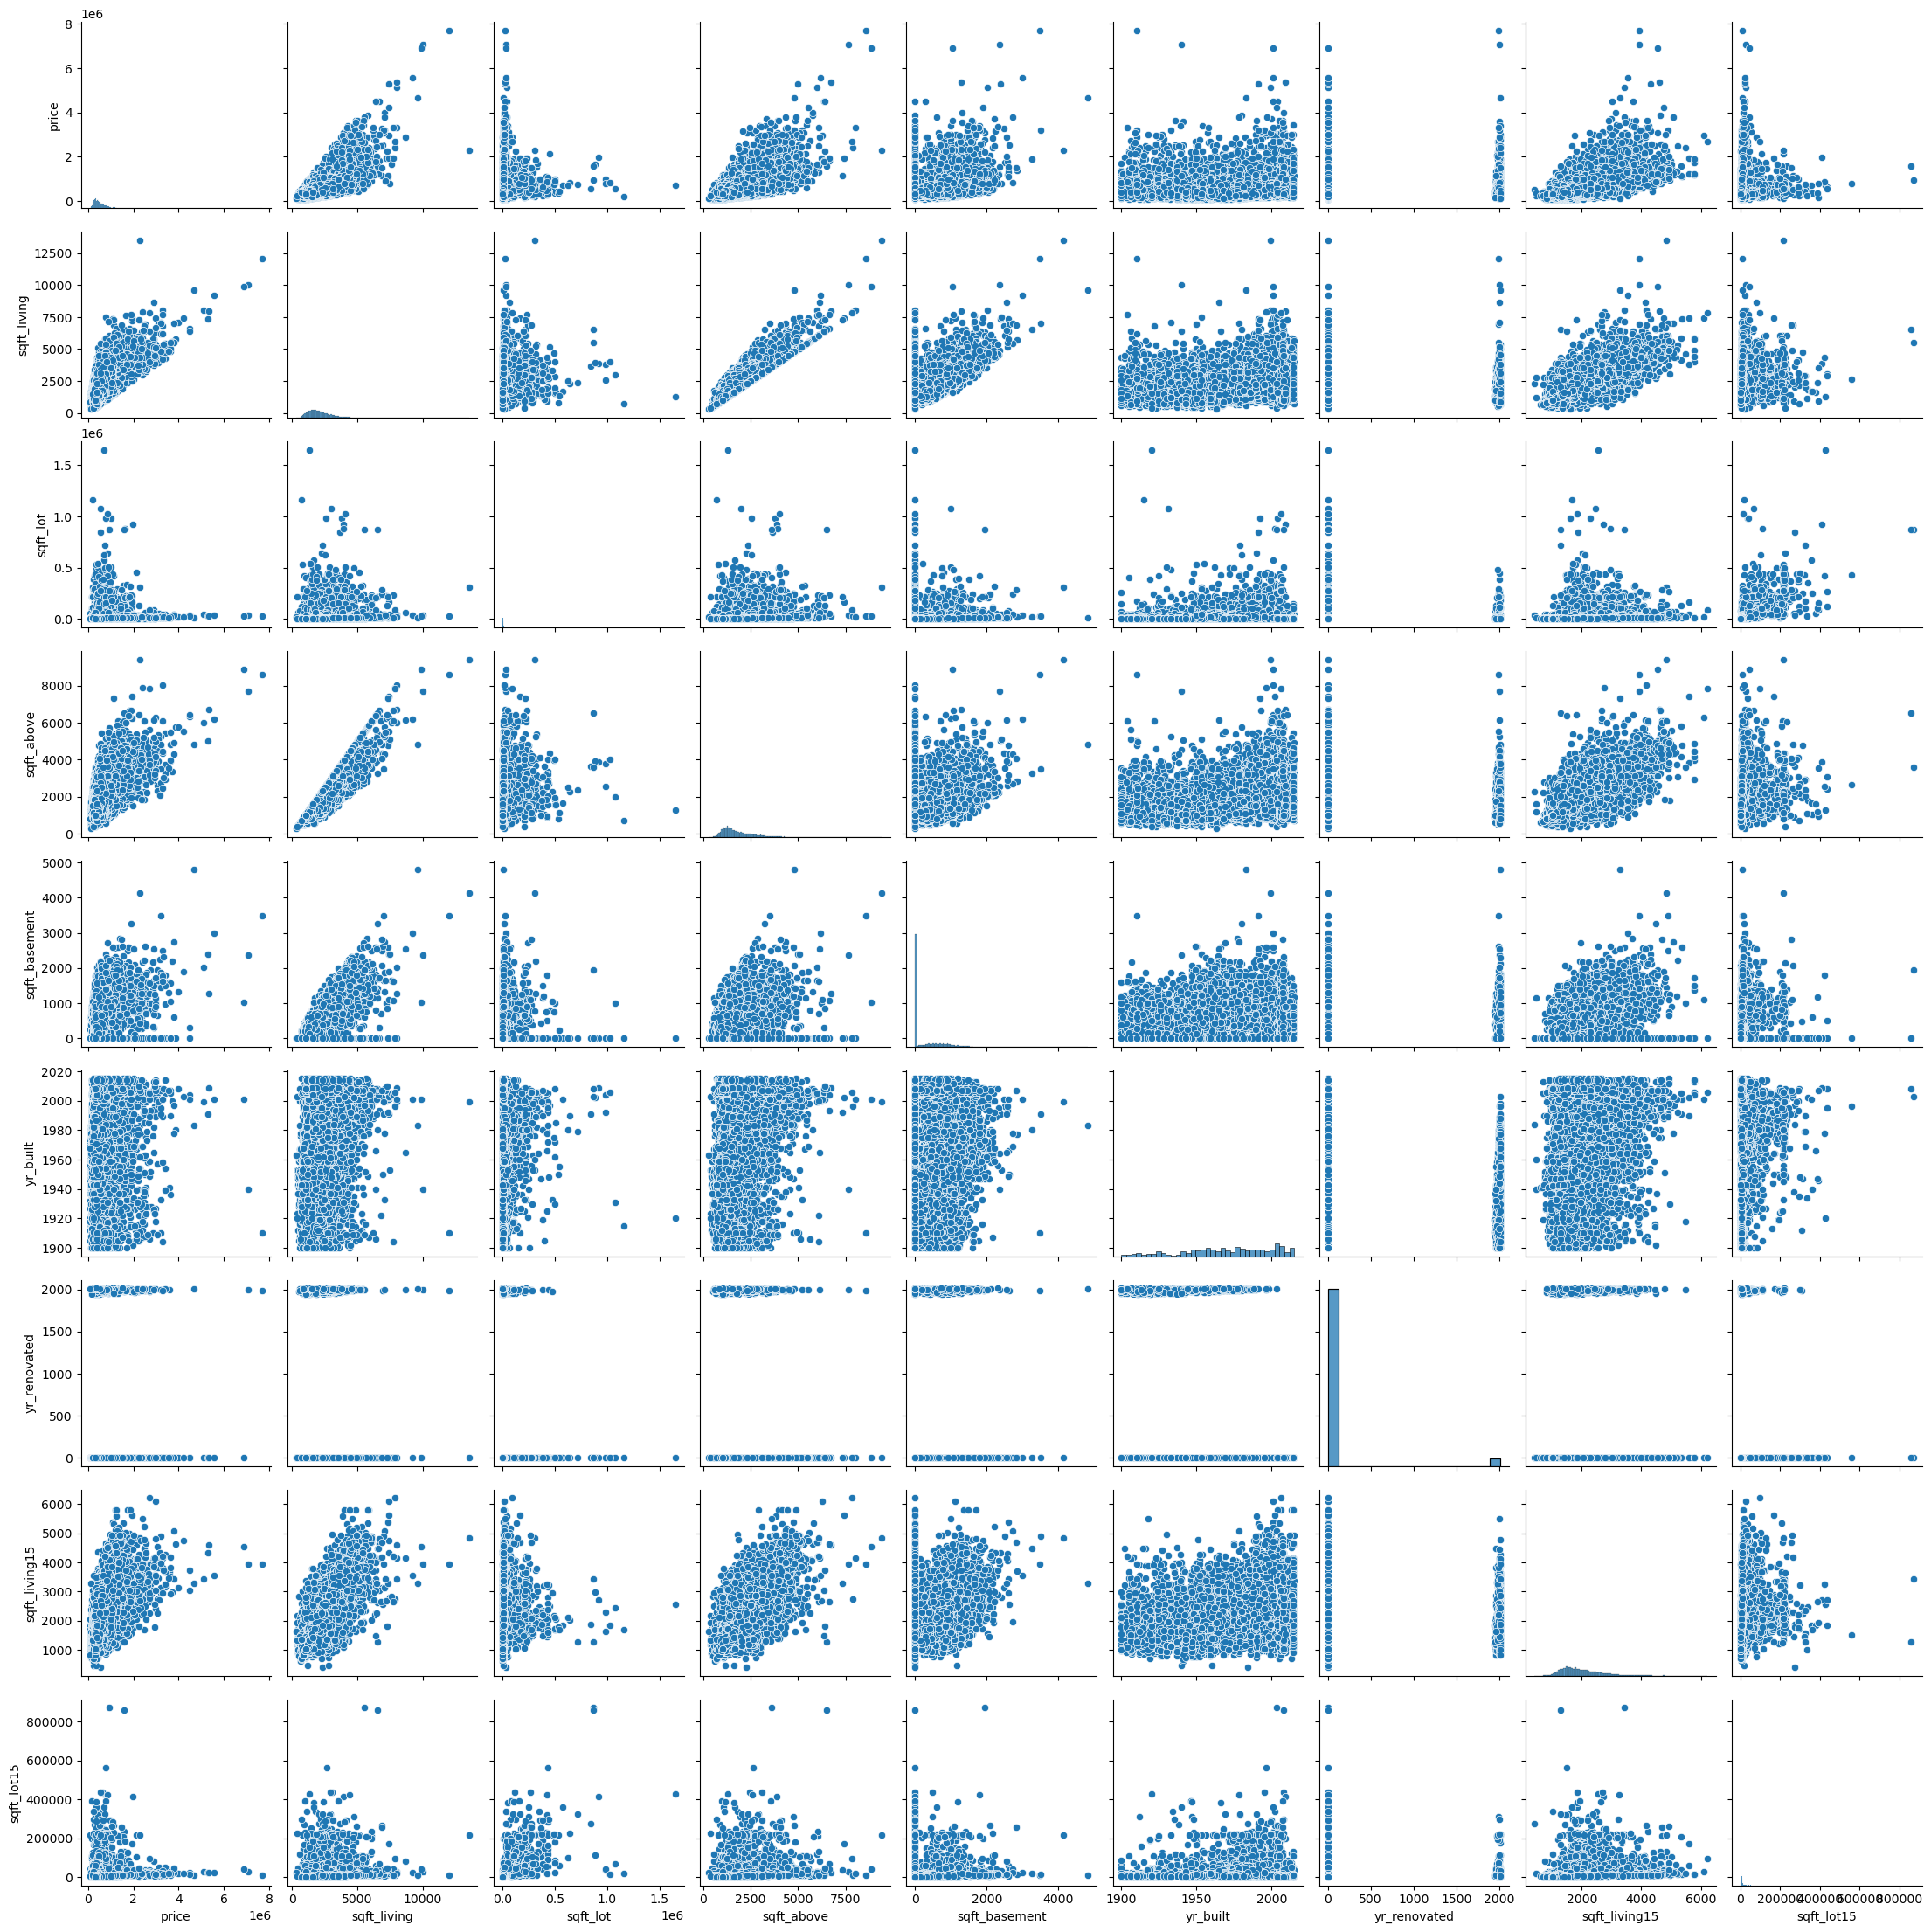

In [490]:
#Analisis gráfico sobre las variables numéricas
sns.pairplot(df_copy, vars=['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                            'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'])
plt.show()

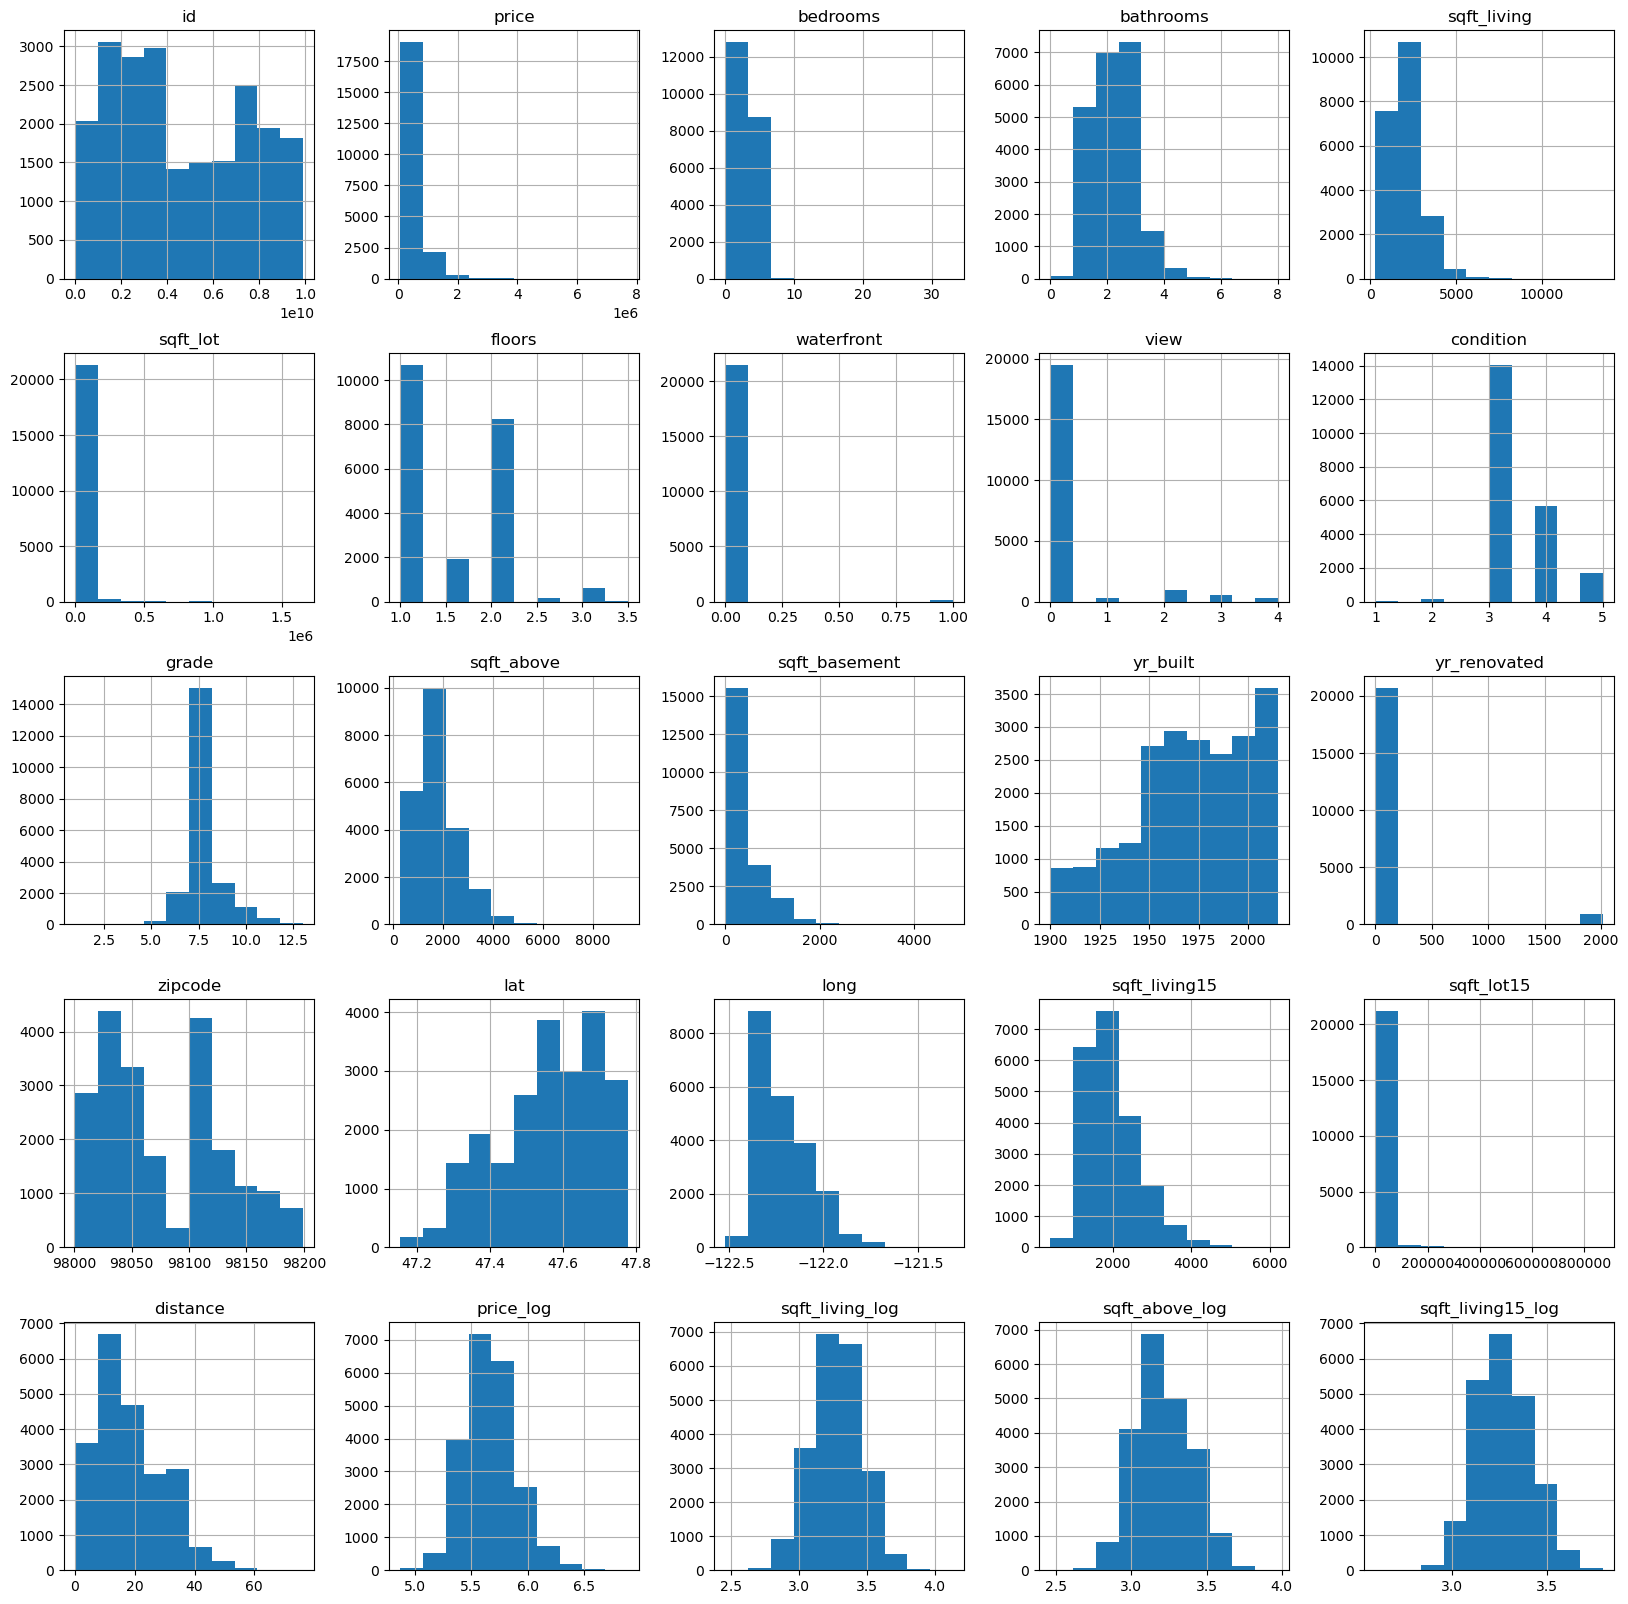

In [492]:
#Histograma
df_copy.hist(figsize=(20,20));
plt.savefig('histplot.png', dpi=300)

Text(0.5, 1.0, 'Plot 1: sqft_living15')

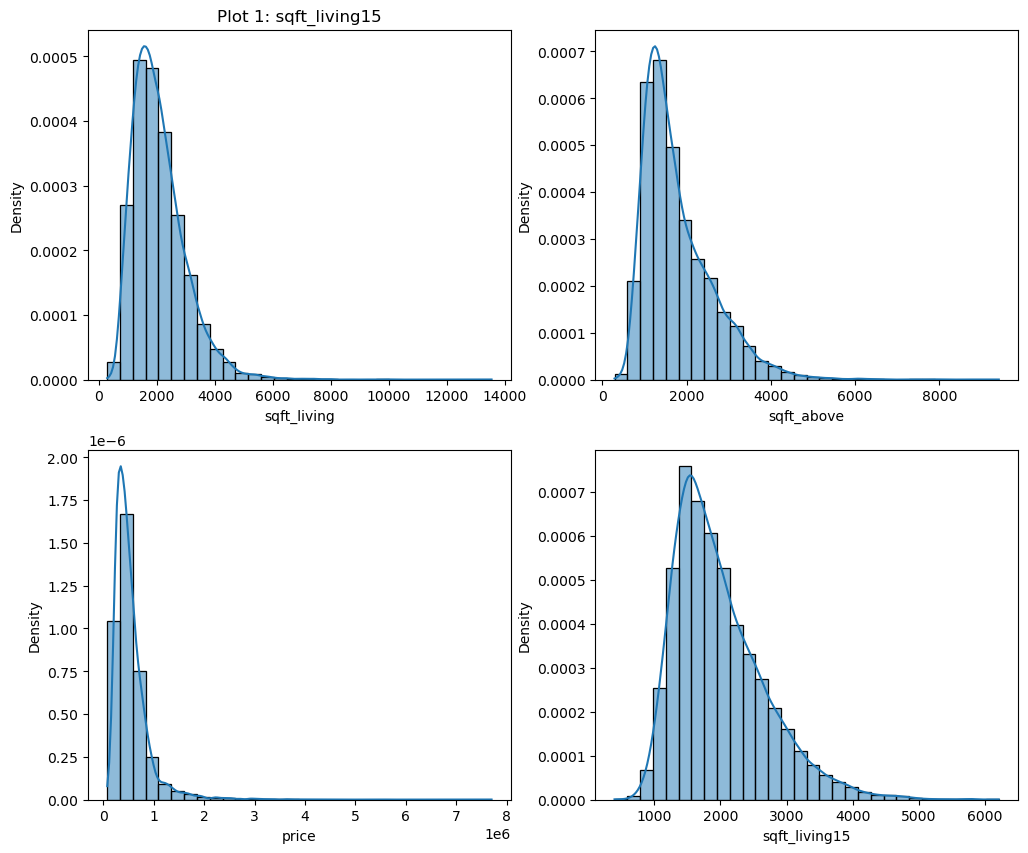

In [634]:
#Analisis de comportamiento normal por cada variable
fig, axes = plt.subplots(2,2, figsize=(12,10))

#Plot 1: SQFT_LIVING
sns.histplot(df_copy['sqft_living'], kde=True, stat='density', bins=30, ax=axes[0,0])
axes[0,0].set_title('Plot 1: sqft_living')

#Plot 1: SQFT_above
sns.histplot(df_copy['sqft_above'], kde=True, stat='density', bins=30, ax=axes[0,1])
axes[0,0].set_title('Plot 1: sqft_above')

#Plot 1: SQFT_BASEMENT
sns.histplot(df_copy['price'], kde=True, stat='density', bins=30, ax=axes[1,0])
axes[0,0].set_title('Plot 1: price')

#Plot 1: SQFT_LIVING15
sns.histplot(df_copy['sqft_living15'], kde=True, stat='density', bins=30, ax=axes[1,1])
axes[0,0].set_title('Plot 1: sqft_living15')

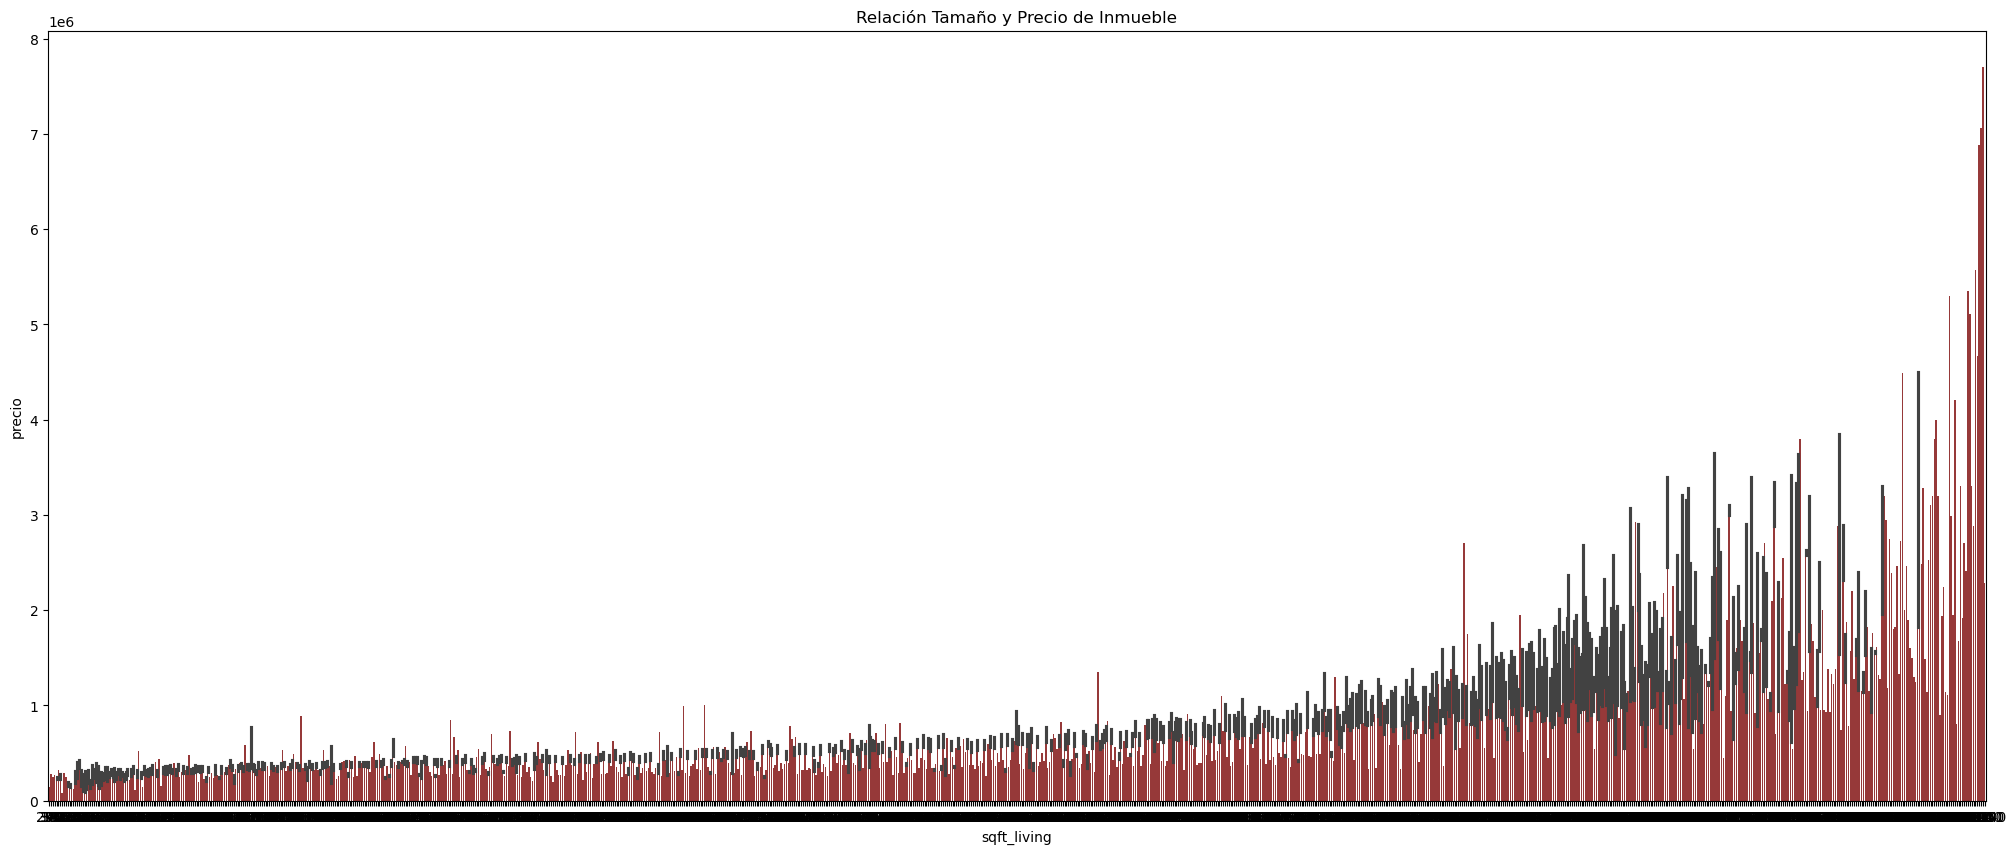

<Figure size 640x480 with 0 Axes>

In [304]:
#Gráfico de precio vs tamaño de la vivienda
fig, axes=plt.subplots(nrows=1, ncols=1, figsize=(25,10))
plt.title('Relación Tamaño y Precio de Inmueble')
plt.xlabel('sqft_living')
plt.ylabel('precio')
sns.barplot(x='sqft_living', y='price', data=df_copy, color='brown')
plt.show()


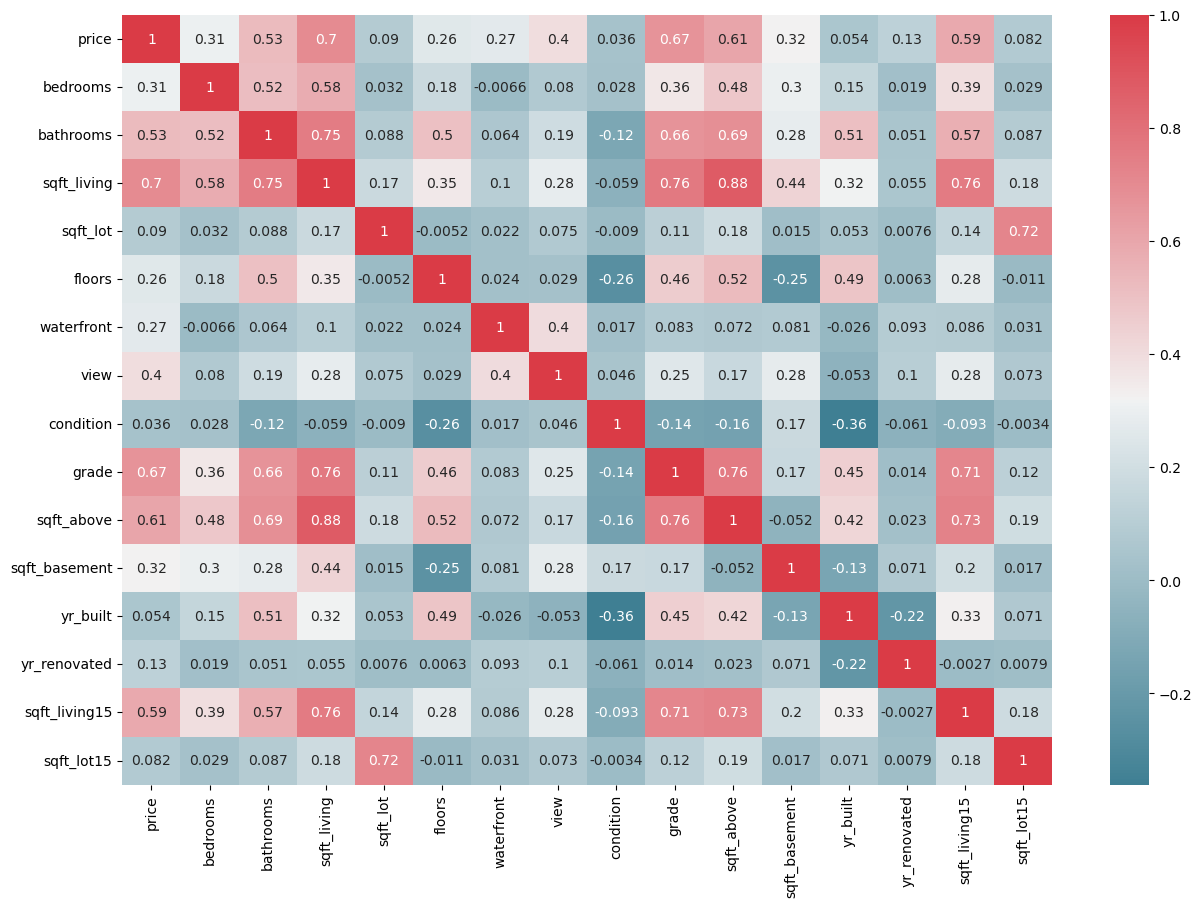

In [494]:
correlation_map(df_copy[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','sqft_living15','sqft_lot15']])
plt.savefig('corr1.png', dpi=300)

Estas revisiones y gráficas nos pueden dar indicios y conclusiones previas al análisis realizado:
- El precio es la variable que guarda más correlación con el resto de variables, dando indicios a que podría ser la variable dependiente del dataset.
- El precio aumenta conforme la vivienda se hace más grande (tanto en tamaño, número de habitaciones, baños, etc)
- La mayoría o gran parte de las variables numéricas *no* siguen una distribución normal, por ello, sería buena realizar una transformación logarítmica.
- A pesar que sí existe una relación entre la longitud y latitud y el precio, se podría realizar una operación sobre ambas variables unificadas y obtener una distancia entre el condominio y una localidad cercana, con el fin de demostrar si el precio aumenta o decrementa dependiendo la distancia.

## 2. Modificación de variables

### 1. Adición de variable distancia

Tomando en consideración la información anterior. Realicé una investigación sobre dónde se encuentran los domicilios del dataset. Buscando en la aplicación de google maps por *(latitud,longitud)* de un punto aleatorio, encontré que las localidades están dentro del estado de Washington. Por ejemplo, seleccionando la localidad *6414100192*, obtenemos la siguiente ubicación.

In [568]:
df_copy[df['id']==6414100192]

id       date     price  bedrooms  bathrooms  sqft_living  \
1  6414100192 2014-12-09 538000.00         3       2.25         2570   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
1      7242    2.00           0     0  ...      7        2170            400   

   yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
1      1951          1991    98125 47.72 -122.32           1690        7639  

[1 rows x 21 columns]

Y realizando la búsqueda de su valor de latitud y longitud *(47.72,-122.32)*. Obtenemos la siguiente ubicación.

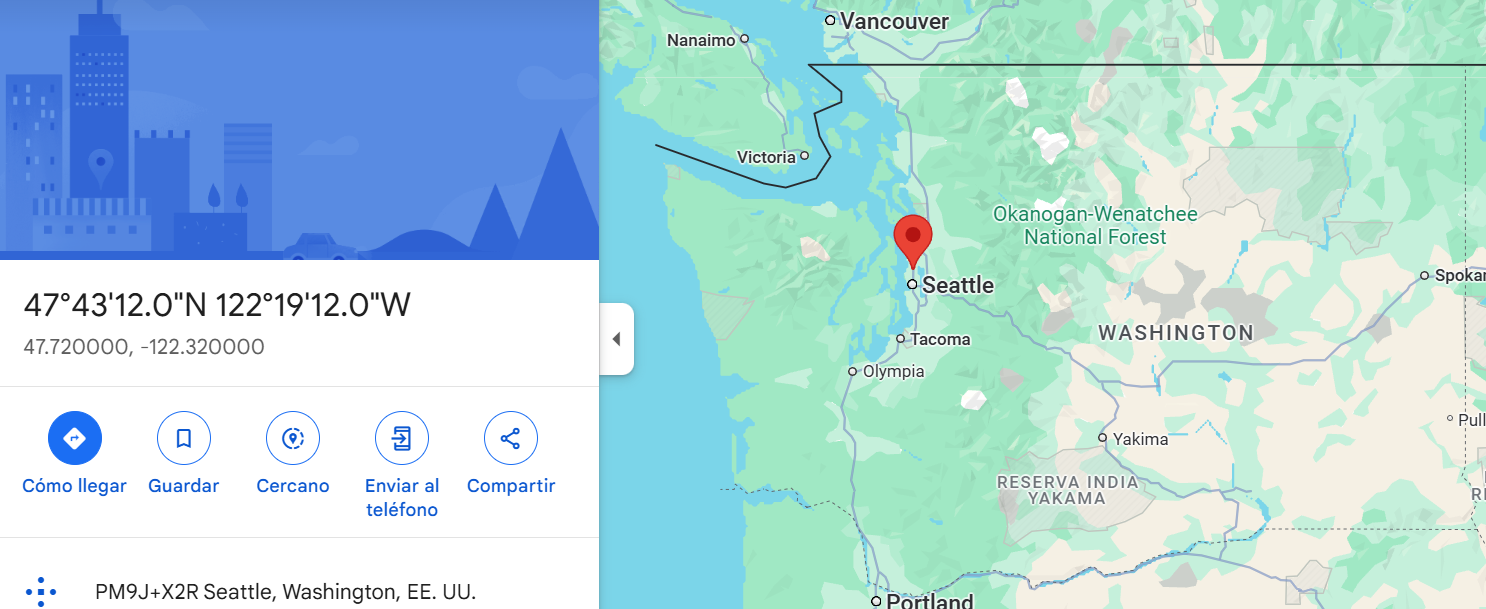


Tal como se observa, en efecto las ubicaciones de las localidades están en la ciudad de Seattle, estado de Washington, aunque este no es el caso para todas. A continuación mostraré una representación gráfica de las viviendas. A pesar que la mayoría están dentro de la ciudad de Seattle, algunas están en estados colindantes.

Tomando como representación Seattle y tras otra investigación sobre qué zona es la más costosa para vivir en esa ciudad (Capitol Hill). Añadiré la distancia entre cada punto (vivienda) hacia el centro de la zona mencionada. En el siguiente gráfico:
- El fondo en *azul celeste* representa el estado de Washington
- Los puntos color *rojo* es cada vivienda dentro del dataset
- El mapa *morado* es la delimitación del estado de Seattle.
- El *punto amarillo* es el punto central del barrio de Capitol Hill.

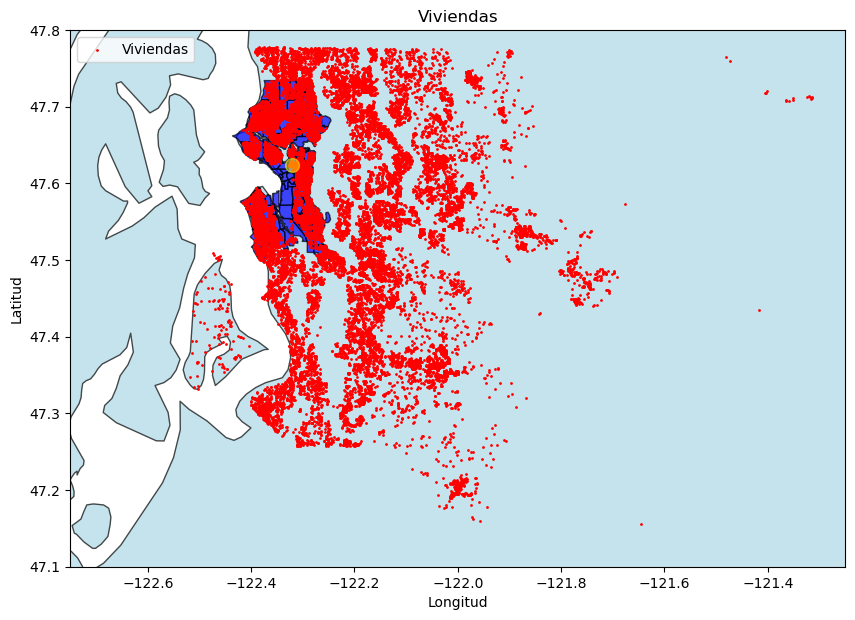

In [555]:
mapa_datos(df_copy)

In [10]:
#Adición de variable distancia
df_copy['distance'] = df_copy.apply(calculate_distance, axis=1)

Para demostrar que este cálculo sí es acercado al real, tomando en consideración la vivienda con id = *7129300520*, con ubicación en *(47.51,-122.26)* tiene una distancia mencionada en google maps de 14.4841 kilometros, mientras que el cálculo obtenido es de 13.42 kilometros. Este valor no es el mismo debido a que el cálculo realizado en este proyecto es lineal, mientras que google maps considera calles, desviaciones, etc. Sin embargo, es un cálculo muy acercado.

In [581]:
df_copy.head(5)

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13 221900.00         3       1.00         1180   
1  6414100192 2014-12-09 538000.00         3       2.25         2570   
2  5631500400 2015-02-25 180000.00         2       1.00          770   
3  2487200875 2014-12-09 604000.00         4       3.00         1960   
4  1954400510 2015-02-18 510000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650    1.00           0     0  ...        1180              0   
1      7242    2.00           0     0  ...        2170            400   
2     10000    1.00           0     0  ...         770              0   
3      5000    1.00           0     0  ...        1050            910   
4      8080    1.00           0     0  ...        1680              0   

   yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  \
0      1955             0    98178 47.51 -122.26           1340        5650   
1      1951          1991    98125 47.72 -122.32           1690        7639   
2      1933             0    98028 47.74 -122.23           2720        8062   
3      1965             0    98136 47.52 -122.39           1360        5000   
4      1987             0    98074 47.62 -122.05           1800        7503   

   distance  
0     13.42  
1     10.80  
2     14.29  
3     12.68  
4     20.76  

[5 rows x 22 columns]

### 2. Modificación de variables logaritmicas

Como mencioné en las conclusiones del EDA, algunas variables no siguen una distribución normal, por ende, se podría realizar una transformación logarítmica para ajustarlas a una distribución normal. Dicho ejercicio se realizará sobre las siguientes variables, a cada variable añadiré 1 por el tema de valores de 0:
- price
- sqft_living
- sqft_above
- sqft_basement
- sqft_living15

In [12]:
#Price_log
df_copy['price_log']=np.log10(df_copy['price'])
#sqft_living log
df_copy['sqft_living_log']=np.log10(df_copy['sqft_living'])
#sqft_above log
df_copy['sqft_above_log']=np.log10(df_copy['sqft_above'])
#sqft_living15
df_copy['sqft_living15_log']=np.log10(df_copy['sqft_living15'])

In [672]:
df_copy.head(5)

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13 221900.00         3       1.00         1180   
1  6414100192 2014-12-09 538000.00         3       2.25         2570   
2  5631500400 2015-02-25 180000.00         2       1.00          770   
3  2487200875 2014-12-09 604000.00         4       3.00         1960   
4  1954400510 2015-02-18 510000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...   lat    long  sqft_living15  \
0      5650    1.00           0     0  ... 47.51 -122.26           1340   
1      7242    2.00           0     0  ... 47.72 -122.32           1690   
2     10000    1.00           0     0  ... 47.74 -122.23           2720   
3      5000    1.00           0     0  ... 47.52 -122.39           1360   
4      8080    1.00           0     0  ... 47.62 -122.05           1800   

   sqft_lot15  distance  price_log  sqft_living_log  sqft_above_log  \
0        5650     13.42       5.35             3.07            3.07   
1        7639     10.80       5.73             3.41            3.34   
2        8062     14.29       5.26             2.89            2.89   
3        5000     12.68       5.78             3.29            3.02   
4        7503     20.76       5.71             3.23            3.23   

   sqft_basement_log  sqft_living15_log  
0               0.00               3.13  
1               5.99               3.23  
2               0.00               3.43  
3               6.81               3.13  
4               0.00               3.26  

[5 rows x 27 columns]

Text(0.5, 1.0, 'Plot 4: sqft_living15')

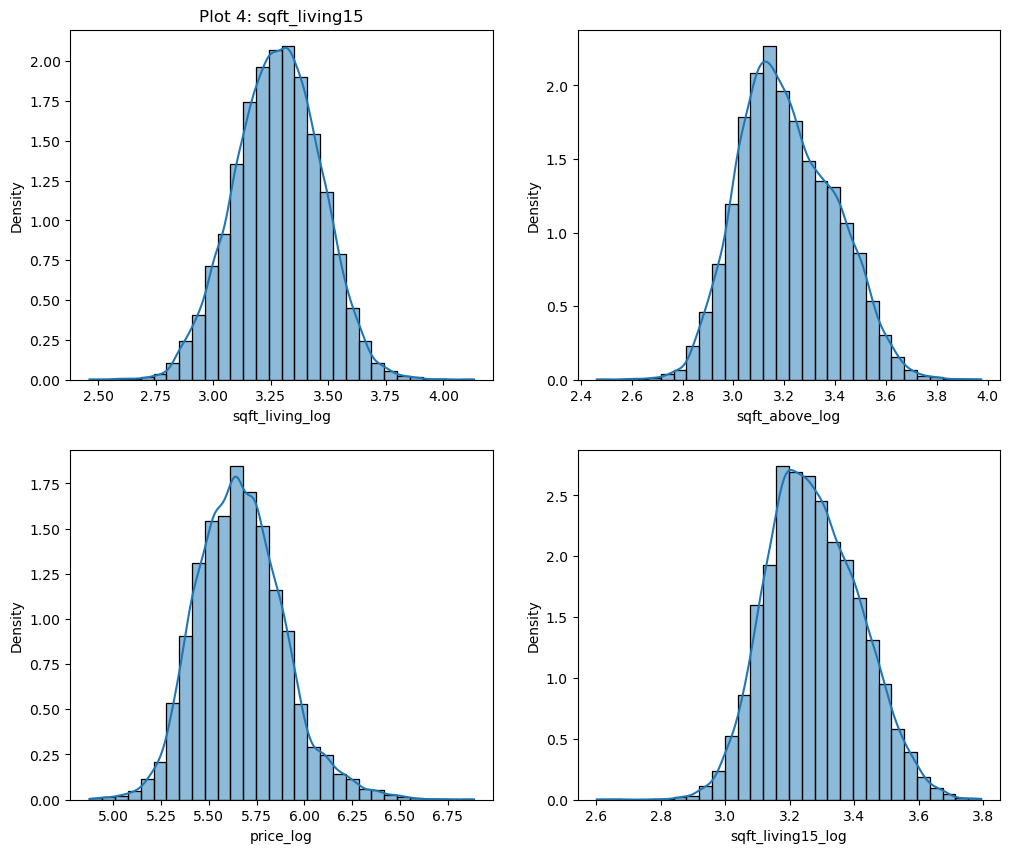

In [674]:
#Analisis de comportamiento normal por cada variable
fig, axes = plt.subplots(2,2, figsize=(12,10))

#Plot 1: SQFT_LIVING
sns.histplot(df_copy['sqft_living_log'], kde=True, stat='density', bins=30, ax=axes[0,0])
axes[0,0].set_title('Plot 1: sqft_living')

#Plot 1: SQFT_above
sns.histplot(df_copy['sqft_above_log'], kde=True, stat='density', bins=30, ax=axes[0,1])
axes[0,0].set_title('Plot 2: sqft_above')

#Plot 3: PRICE
sns.histplot(df_copy['price_log'], kde=True, stat='density', bins=30, ax=axes[1,0])
axes[0,0].set_title('Plot 3: price')

#Plot 4: SQFT_LIVING_15
sns.histplot(df_copy['sqft_living15_log'], kde=True, stat='density', bins=30, ax=axes[1,1])
axes[0,0].set_title('Plot 4: sqft_living15')

Las variables, tras haber sido agregadas, se procede a realizar una evaluación de las mejores propuestas para modelar.

### 3. Conclusiones

Tras haber hecho la modificación y adición de variables, el mapa de correlación mostrará el cambio de las variables añadidas y las nuevas.

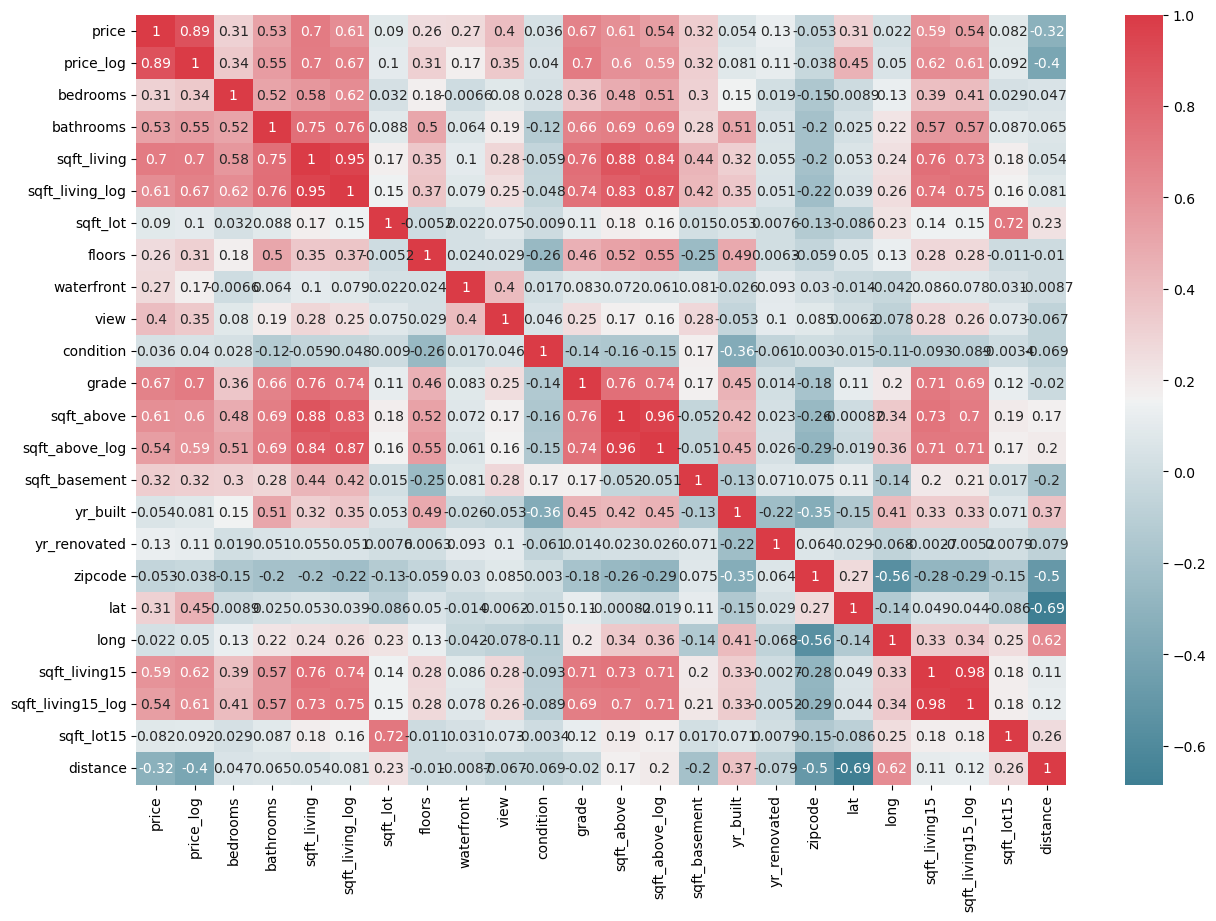

In [498]:
#Mapa de correlación considerando las variables modificadas
correlation_map(df_copy[['price','price_log','bedrooms','bathrooms','sqft_living','sqft_living_log','sqft_lot','floors','waterfront','view','condition','grade',
                         'sqft_above','sqft_above_log','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_living15_log','sqft_lot15',
                         'distance']])
plt.savefig('corr2.png', dpi=300)

Con respecto a las variables agregadas y modificadas:
- **Precio en Logaritmo**: En general, casi todas las variables incrementaron su correlación, exceptuando *waterfront, view, sqft_above, yr_renovated*. Aunque dicha disminución fue baja (màxima para waterfront de .1). Por ende, la modificación de dicha variable fue correcta. 
- **Distance**: La distancia mostró una relación baja con el precio del inmueble, aún así la mantendré en el modelo en caso que ayude en algún modelo.
- **sqft_living en logaritmo**: En el caso de la relación con *price_log*, decrementa un poco, sin embargo, en la mayoría del resto de variables sí incrementó. Por ende, dejaremos esa variable transformada.
- **sqft_above en logaritmo**: Caso similar a *sqft_living_log*, la relación con el precio decrementa en poca medida, sin embargo, en el resto de la mayoría de las variables, incrementa.
- **sqft_living15 en logaritmo**: Dado que esta variable es una transformación de la variable *sqft_living*, su relación con el resto de variables es parecido.

In [14]:
df_final = df_copy[['price_log','bedrooms','bathrooms','sqft_living_log','sqft_lot','floors','waterfront','view','condition','grade',
                    'sqft_above_log','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15_log','sqft_lot15',
                    'distance']]

## 3. Propuestas de modelos

Dado que ya se decidió por realizar un modelo predictivo sobre la variable **price**, se propondrán distintos modelos de regresión, dentro de los cuales serán:
1. Modelo de regresión lineal: Este modelo se tiene que realizar sobre 2 variables *[price, X]* donde X será una variable que esté más relacionada con la variable dependiente. Se harán de igual manera distintos ejercicios.
2. Modelo de regresión múltiple: A diferencia de la regresión lineal, la regresión múltiple permite más variables independentes, de tal manera que estará de esta manera: $[[price], [X_{1},X_{2},X_{3},...X_{n}]]$ Donde $X_{i}$ corresponde a distintas variables independientes, donde de igual manera se harán distintos ejercicios.
3. Modelo de Regresión Polinomial: Por último, el modelo de regresión polinomial incorporará el resto de variables y ajustará de manera más armónica

In [470]:
#División de set entrenamiento y test (Será el mismo para todas las regresiones [lineales, multiples y polinomiales])
X = df_final.drop('price_log', axis=1)
y = df_final['price_log']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=7)

lm = linear_model.LinearRegression()

### 1. Regresión lineal simple

Con el fin de determinar qué variable será la que se considerará en el modelo, tomaré las que tienen con coeficiente de correlación más alto con la variable de **price_log**. Acorde al gráfico de correlación en *Conclusiones* de la adición/transformación de variables, encontramos las siguientes variables.
- grade: Correlación más alta de .7
- sqft_living_log: Correlación de .67
- sqft_above_log: Correlación de .59
- sqft_living15_log: Correlación de .61

In [456]:
train_data, test_data = train_test_split(df_final, test_size = .2, random_state=7)

#### Regresión lineal (price_log, grade)

In [370]:
#División de set entrenamiento y test
X_train = np.array(train_data['grade']).reshape(-1,1)
y_train = np.array(train_data['price_log']).reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
#Fit
lm.fit(X_train,y_train)

X_test = np.array(test_data['grade']).reshape(-1,1)
y_test = np.array(test_data['price_log']).reshape(-1,1)
print(X_test.shape)
print(y_test.shape)
#Prediccion
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

(17290, 1)
(17290, 1)
(4323, 1)
(4323, 1)


In [372]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.026288261714938987
Regresion lineal (price, grade) test data MAE = 0.12948321569557816
Regresion lineal (price, grade) test data R2 = 0.485107166455229

Regresion lineal (price, grade) train data MSE = 0.02644699545691727
Regresion lineal (price, grade) train data MAE = 0.12981112291979133
Regresion lineal (price, grade) train data R2 = 0.49752410897087707


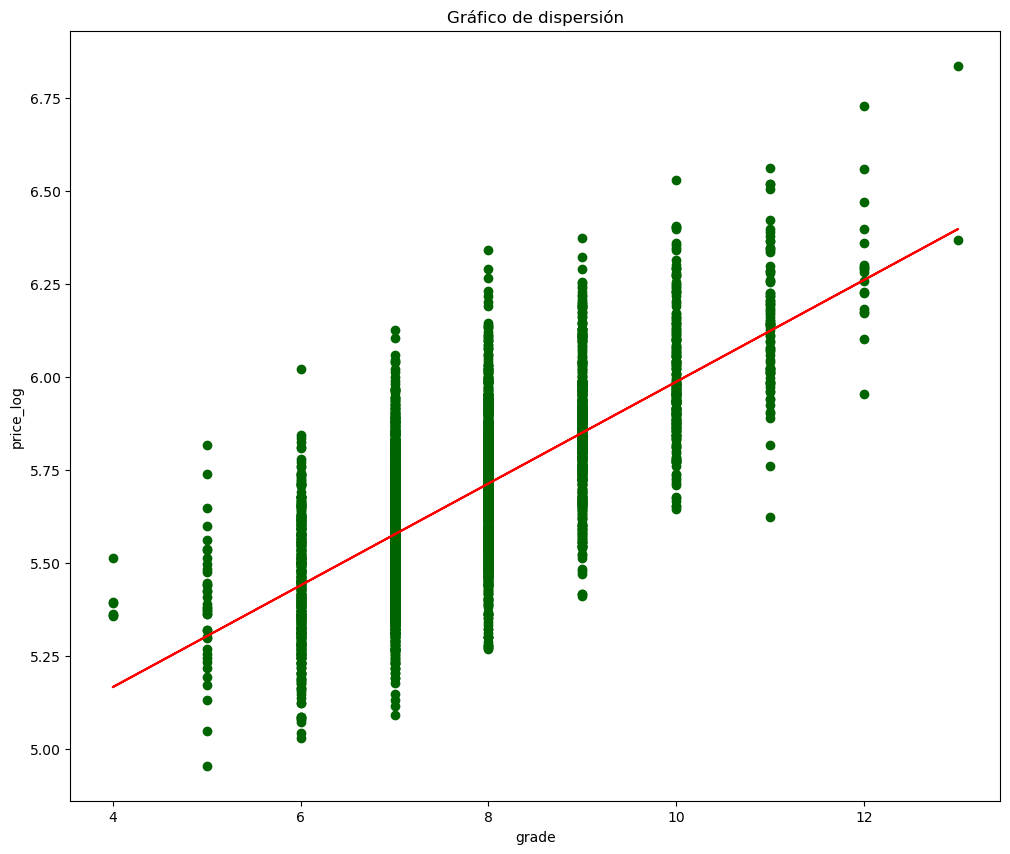

In [374]:
rm_plot(X_test, y_test, 'grade')

#### Regresión lineal (price, sqft_living_log)

In [376]:
#División de set entrenamiento y test
X_train = np.array(train_data['sqft_living_log']).reshape(-1,1)
y_train = np.array(train_data['price_log']).reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
#Fit
lm.fit(X_train,y_train)

X_test = np.array(test_data['sqft_living_log']).reshape(-1,1)
y_test = np.array(test_data['price_log']).reshape(-1,1)
print(X_test.shape)
print(y_test.shape)
#Prediccion
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

(17290, 1)
(17290, 1)
(4323, 1)
(4323, 1)


In [378]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.028215453444315055
Regresion lineal (price, grade) test data MAE = 0.13665609446569835
Regresion lineal (price, grade) test data R2 = 0.44736038726219507

Regresion lineal (price, grade) train data MSE = 0.028556426618124037
Regresion lineal (price, grade) train data MAE = 0.13669741183107098
Regresion lineal (price, grade) train data R2 = 0.4574462746467993


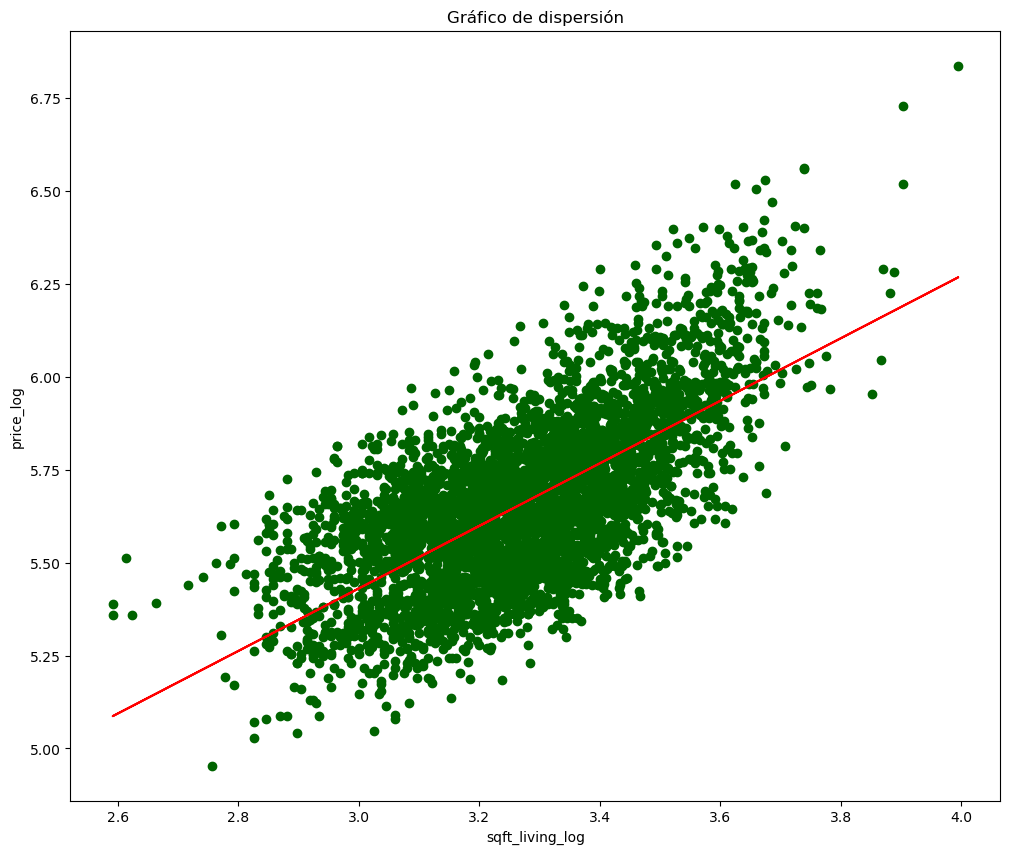

In [380]:
rm_plot(X_test, y_test, 'sqft_living_log')

#### Regresión lineal (price, sqft_above_log)

In [458]:
#División de set entrenamiento y test
X_train = np.array(train_data['sqft_above_log']).reshape(-1,1)
y_train = np.array(train_data['price_log']).reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
#Fit
lm.fit(X_train,y_train)

X_test = np.array(test_data['sqft_above_log']).reshape(-1,1)
y_test = np.array(test_data['price_log']).reshape(-1,1)
print(X_test.shape)
print(y_test.shape)
#Prediccion
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

(17290, 1)
(17290, 1)
(4323, 1)
(4323, 1)


In [460]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.03386157119784406
Regresion lineal (price, grade) test data MAE = 0.1483567252645952
Regresion lineal (price, grade) test data R2 = 0.3367731753664033

Regresion lineal (price, grade) train data MSE = 0.0344530908594922
Regresion lineal (price, grade) train data MAE = 0.14937059660432023
Regresion lineal (price, grade) train data R2 = 0.34541344945848196


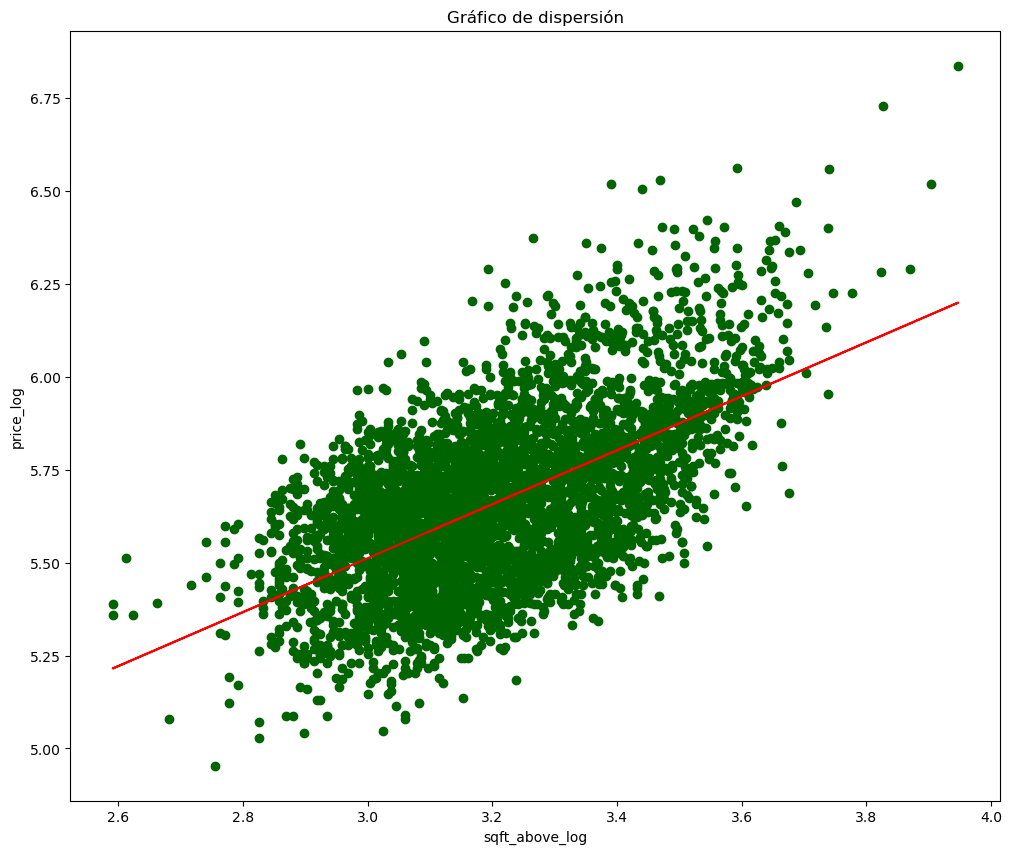

In [388]:
rm_plot(X_test, y_test, 'sqft_above_log')

#### Regresión lineal (price, sqft_living15_log)

In [466]:
#División de set entrenamiento y test
X_train = np.array(train_data['sqft_living15_log']).reshape(-1,1)
y_train = np.array(train_data['price_log']).reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
#Fit
lm.fit(X_train,y_train)

X_test = np.array(test_data['sqft_living15_log']).reshape(-1,1)
y_test = np.array(test_data['price_log']).reshape(-1,1)
print(X_test.shape)
print(y_test.shape)
#Prediccion
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

(17290, 1)
(17290, 1)
(4323, 1)
(4323, 1)


In [468]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.03272734112196989
Regresion lineal (price, grade) test data MAE = 0.14273703377131944
Regresion lineal (price, grade) test data R2 = 0.35898867763092446

Regresion lineal (price, grade) train data MSE = 0.033106062589284196
Regresion lineal (price, grade) train data MAE = 0.14376167506280974
Regresion lineal (price, grade) train data R2 = 0.37100611957546326


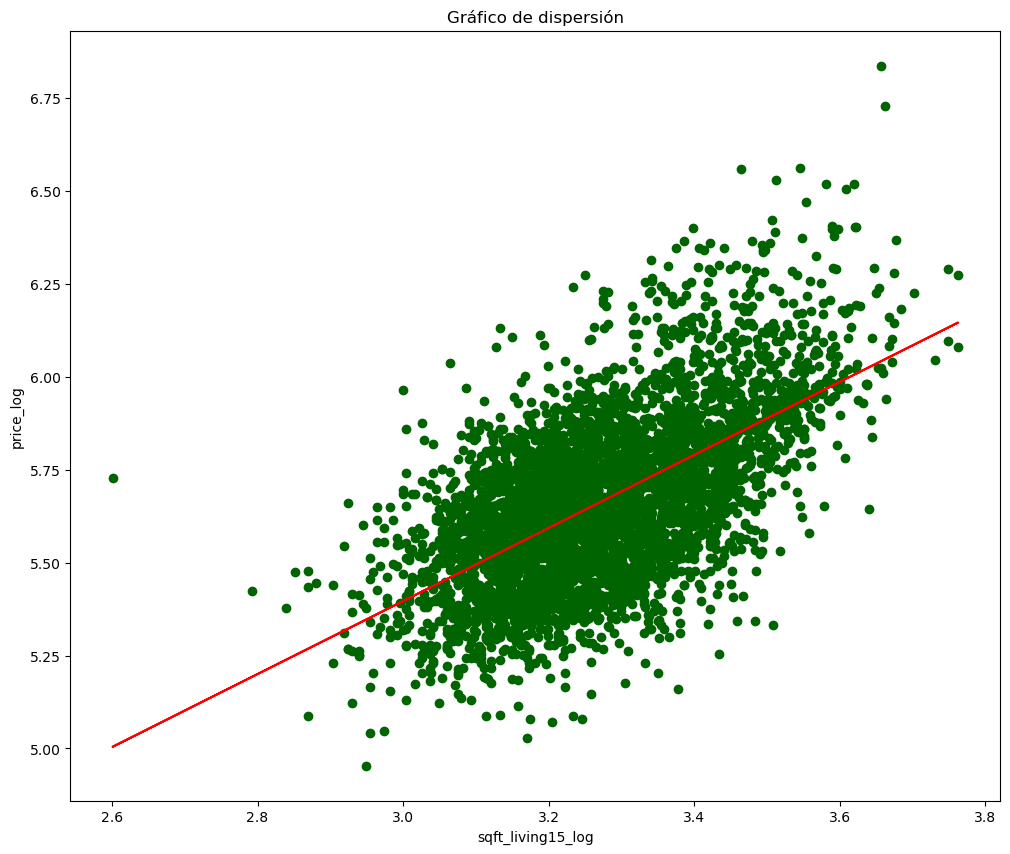

In [424]:
rm_plot(X_test, y_test, 'sqft_living15_log')

### 2. Modelo regresión múltiple

En este ejercicio, realizaremos 2 modelos diferentes, uno que considere todas las variables del data set, por otro lado, consideraremos solo las que tienen más relación con la variable dependiente *(price)*.

#### 1. Considerando todas las variables

In [398]:
lm.fit(X_train, y_train)
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

In [400]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17290, 19)
(17290,)
(4323, 19)
(4323,)


In [402]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.00979794658095882
Regresion lineal (price, grade) test data MAE = 0.07682772631680869
Regresion lineal (price, grade) test data R2 = 0.8080933409483178

Regresion lineal (price, grade) train data MSE = 0.00962739923680606
Regresion lineal (price, grade) train data MAE = 0.07547426234740935
Regresion lineal (price, grade) train data R2 = 0.8170856111921041


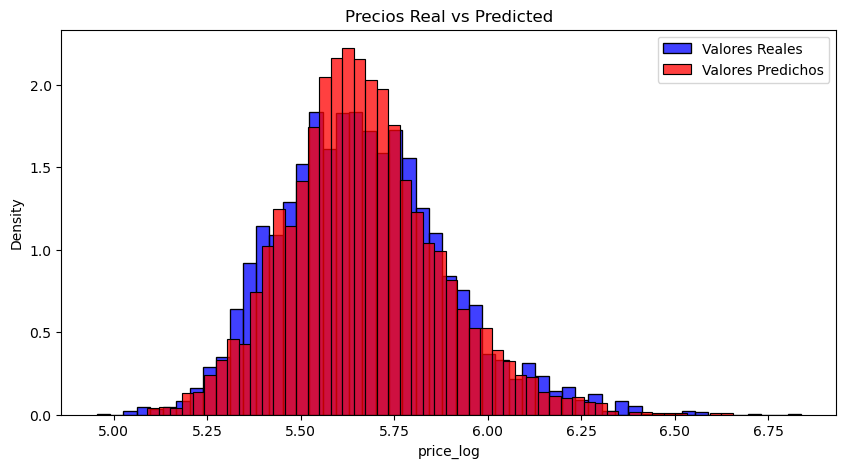

In [408]:
Predictive_Model(lm, X_train, X_test, y_train ,y_test)

#### 2. Considerando las 10 variables más relevantes del modelo

De acorde al gráfico de correlación obtenido en las conclusiones del EDA, podemos elegir las variables con mayor relación a la variable dependiente.

In [410]:
variables = ['sqft_living_log','grade','sqft_above_log','sqft_living15_log','bathrooms','lat','floors','view','sqft_basement','waterfront']
X = df_final.drop('price_log', axis=1)
X = X[variables]
y = df_final['price_log']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=7)

lm.fit(X_train, y_train)
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

In [412]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17290, 10)
(17290,)
(4323, 10)
(4323,)


In [414]:
#Test metricas
mse,mae,r2 = metricas(y_test, test_pred)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, train_pred)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.014257465761699013
Regresion lineal (price, grade) test data MAE = 0.09303738492079733
Regresion lineal (price, grade) test data R2 = 0.7207473424902412

Regresion lineal (price, grade) train data MSE = 0.013950706529532762
Regresion lineal (price, grade) train data MAE = 0.0913581535469532
Regresion lineal (price, grade) train data R2 = 0.7349455553341759


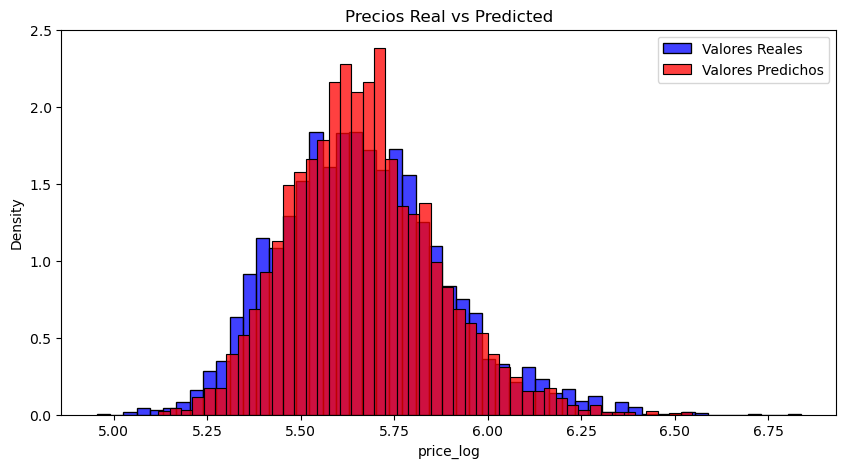

In [416]:
Predictive_Model(lm, X_train, X_test, y_train ,y_test)

### 3. Modelo regresion Polinomial

Por último, se generará un modelo polinomial para ajustar los datos acorde a la distribución que tengan los mismos. De igual manera se harán 2 modelos, uno considerando todas las variables y el otro solo las 10 variables más relacionadas (en cada uno se elegirá si 2 o 3 grados)

#### 1. Considerando todas las variables

In [472]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=7)

pm = PolynomialFeatures(degree=2)
X_train_poly = pm.fit_transform(X_train)
X_test_poly = pm.fit_transform(X_test)

poly = linear_model.LinearRegression()
poly.fit(X_train_poly, y_train)

poly_pred_train = poly.predict(X_train_poly)
poly_pred_test = poly.predict(X_test_poly)

In [474]:
#Test metricas
mse,mae,r2 = metricas(y_test, poly_pred_test)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, poly_pred_train)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.006879543001604858
Regresion lineal (price, grade) test data MAE = 0.060755417880256755
Regresion lineal (price, grade) test data R2 = 0.8652544079178708

Regresion lineal (price, grade) train data MSE = 0.006208552826030721
Regresion lineal (price, grade) train data MAE = 0.058876724996202
Regresion lineal (price, grade) train data R2 = 0.8820414924506967


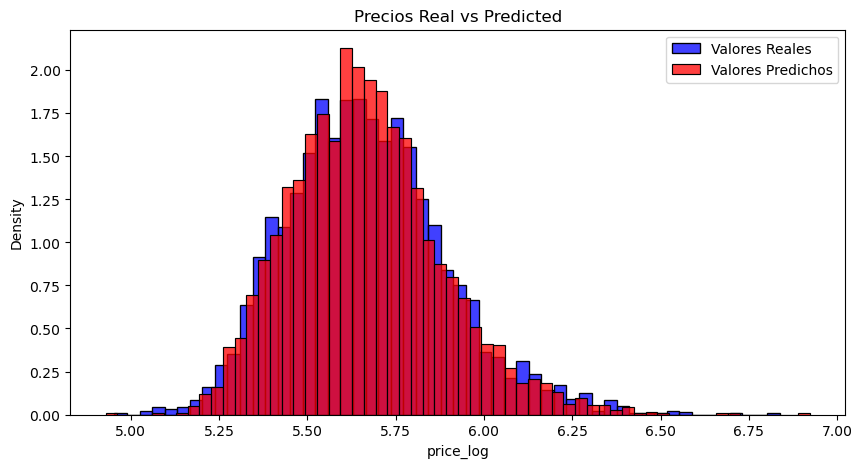

In [476]:
Predictive_Model(poly, X_train_poly, X_test_poly, y_train ,y_test)

#### 2. Considerando variables más relacionadas

In [480]:
variables = ['sqft_living_log','grade','sqft_above_log','sqft_living15_log','bathrooms','lat','floors','view','sqft_basement','waterfront']
X = df_final.drop('price_log', axis=1)
X = X[variables]
y = df_final['price_log']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=7)

pm = PolynomialFeatures(degree=2)
X_train_poly = pm.fit_transform(X_train)
X_test_poly = pm.fit_transform(X_test)

poly = linear_model.LinearRegression()
poly.fit(X_train_poly, y_train)

poly_pred_train = poly.predict(X_train_poly)
poly_pred_test = poly.predict(X_test_poly)

In [482]:
#Test metricas
mse,mae,r2 = metricas(y_test, poly_pred_test)
print(f'Regresion lineal (price, grade) test data MSE = {mse}')
print(f'Regresion lineal (price, grade) test data MAE = {mae}')
print(f'Regresion lineal (price, grade) test data R2 = {r2}\n')

#Train metricas
mse,mae,r2 = metricas(y_train, poly_pred_train)
print(f'Regresion lineal (price, grade) train data MSE = {mse}')
print(f'Regresion lineal (price, grade) train data MAE = {mae}')
print(f'Regresion lineal (price, grade) train data R2 = {r2}')

Regresion lineal (price, grade) test data MSE = 0.012647346360576765
Regresion lineal (price, grade) test data MAE = 0.08657386026466617
Regresion lineal (price, grade) test data R2 = 0.7522838111156324

Regresion lineal (price, grade) train data MSE = 0.012157872090126925
Regresion lineal (price, grade) train data MAE = 0.08447674730078185
Regresion lineal (price, grade) train data R2 = 0.7690082557220389


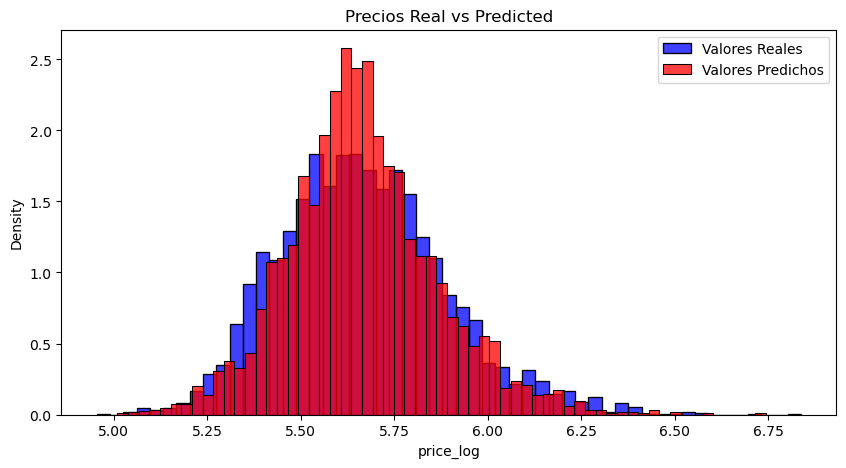

In [484]:
Predictive_Model(poly, X_train_poly, X_test_poly, y_train ,y_test)

### 4. Cross Validation

Con el fin de demostrar que los modelos propuestos actúan de manera correcta, la elección fue la adecuada y evitar un overfitting en el caso de la regresión polinomial, se realiza una validación cruzada.

In [ ]:
#División de set entrenamiento y test (Será el mismo para todas las regresiones [lineales, multiples y polinomiales])
X = df_final.drop('price_log', axis=1)
y = df_final['price_log']

Validación cruzada para modelo regresión lineal múltiple

In [516]:
#linear multiple regression
lm = linear_model.LinearRegression()
lm_cv_r2 = cross_val_score(lm, X, y, cv=cv_folds, scoring='r2')
lm_cv_mse = cross_val_score(lm, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
lm_cv_mae = cross_val_score(lm, X, y, cv=cv_folds, scoring='neg_mean_absolute_error')

print(f"Linear Regression R2: Mean = {np.mean(lm_cv_r2)}, Std = {np.std(lm_cv_r2)}")
print(f"Linear Regression MSE: Mean = {-np.mean(lm_cv_mse)}, Std = {np.std(lm_cv_mse)}")
print(f"Linear Regression MAE: Mean = {-np.mean(lm_cv_mae)}, Std = {np.std(lm_cv_mae)}")

Linear Regression R2: Mean = 0.7301970666511297, Std = 0.016177980292701552
Linear Regression MSE: Mean = 0.014049465886600207, Std = 0.001282605517850201
Linear Regression MAE: Mean = 0.09184386282661998, Std = 0.005751632909087824


In [518]:
#Predicciones para lm
lm_predictions = cross_val_predict(lm, X, y, cv=10)
lm_r2 = metrics.r2_score(y, lm_predictions)
lm_mse = metrics.mean_squared_error(y, lm_predictions)
lm_mae = metrics.mean_absolute_error(y, lm_predictions)

#Métricas
print(f"Linear Regression (Predictions) R2: {lm_r2}, MSE: {lm_mse}, MAE: {lm_mae}")

Linear Regression (Predictions) R2: 0.731457769309689, MSE: 0.014049543929459144, MAE: 0.09184420889338761


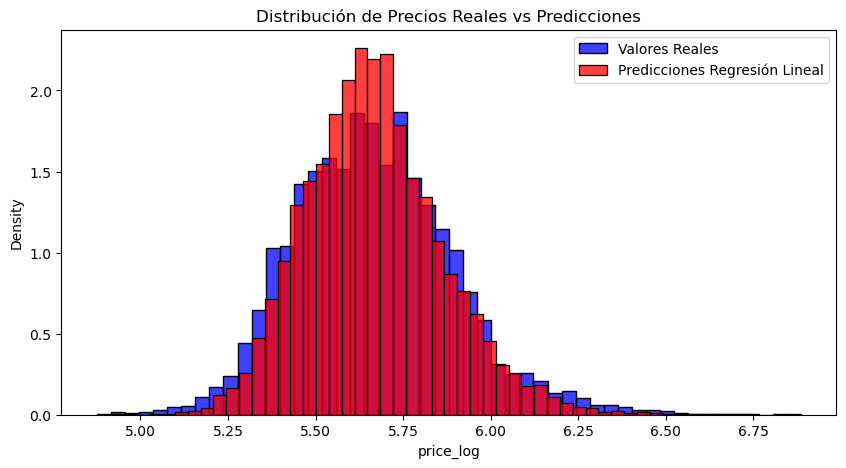

In [532]:
#Utilizando la función de Predictive_Model, modificando un poco
plt.figure(figsize=(10,5))
sns.histplot(y, kde=False, color='blue', label='Valores Reales', stat='density', bins=50)
sns.histplot(lm_predictions, kde=False, color='red', label='Predicciones Regresión Lineal', stat='density', bins=50)
plt.title("Distribución de Precios Reales vs Predicciones")
plt.legend()
plt.show()

Regresión polinomial

In [520]:
#polynomial regression
pm = PolynomialFeatures(degree=2)
X_poly =  pm.fit_transform(X)
pm_cv_r2 = cross_val_score(lm, X_poly, y, cv=10, scoring='r2')
pm_cv_mse = cross_val_score(lm, X_poly, y, cv=10, scoring='neg_mean_squared_error')
pm_cv_mae = cross_val_score(lm, X_poly, y, cv=10, scoring='neg_mean_absolute_error')

# métricas
print(f"Polynomial Regression R2: Mean = {np.mean(pm_cv_r2)}, Std = {np.std(pm_cv_r2)}")
print(f"Polynomial Regression MSE: Mean = {-np.mean(pm_cv_mse)}, Std = {np.std(pm_cv_mse)}")
print(f"Polynomial Regression MAE: Mean = {-np.mean(pm_cv_mae)}, Std = {np.std(pm_cv_mae)}")

Polynomial Regression R2: Mean = 0.7617839676632853, Std = 0.012187338600240434
Polynomial Regression MSE: Mean = 0.01240470178119513, Std = 0.0010885834290447509
Polynomial Regression MAE: Mean = 0.08541671697727503, Std = 0.004320905004234753


In [521]:
#Predicciones para PM
pm_predictions = cross_val_predict(lm, X_poly, y, cv=10)
pm_r2 = metrics.r2_score(y, pm_predictions)
pm_mse = metrics.mean_squared_error(y, pm_predictions)
pm_mae = metrics.mean_absolute_error(y, pm_predictions)

print(f"Polynomial Regression (Predictions) R2: {pm_r2}, MSE: {pm_mse}, MAE: {pm_mae}")

Polynomial Regression (Predictions) R2: 0.7628959547038003, MSE: 0.012404766623403255, MAE: 0.08541697433075894


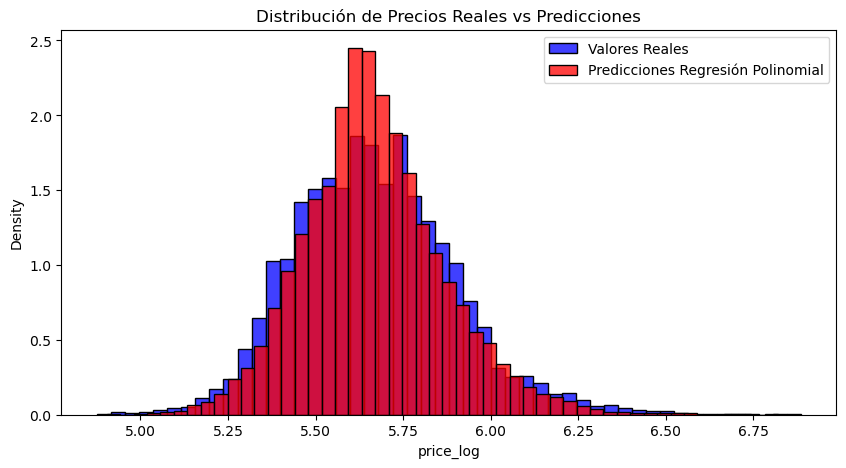

In [534]:
#Utilizando la función de Predictive_Model, modificando un poco
plt.figure(figsize=(10,5))
sns.histplot(y, kde=False, color='blue', label='Valores Reales', stat='density', bins=50)
sns.histplot(pm_predictions, kde=False, color='red', label='Predicciones Regresión Polinomial', stat='density', bins=50)
plt.title("Distribución de Precios Reales vs Predicciones")
plt.legend()
plt.show()